## Retrieve a Specific Dataset:
Using any of the other API’s available in the above link, construct a dataset using a query that you have put together and fetched data for via the API. Use the examples listed as guidance on how to construct these queries

In [162]:
import requests
import pandas as pd

### Return first page of API query call

In [175]:
""" 
API SPECS
"""

# endpoint URL for Open Library search API
url = "https://openlibrary.org/search.json"

# Query parameters
q_params = {
    'q': 'first_publish_year:2019 AND (NOT publisher:Independently Published)',
    'sort': 'random',
    'fields': 'first_publish_year,title,author_name,language,number_of_pages_median,publisher,format,subject,ratings_average,ratings_sortable,ratings_count, readinglog_count, want_to_read_count, currently_reading_count, already_read_count,first_sentence',
    ## ,
    #'page': 1,  # Start with the first page
    'limit': 1000  # Number of results per page
}


"""
# Function to fetch data from the API
def fetch_openlib(params):
    response = requests.get(url, params=q_params)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error with the request, status code:", response.status_code)
        return None
"""

'\n# Function to fetch data from the API\ndef fetch_openlib(params):\n    response = requests.get(url, params=q_params)\n    if response.status_code == 200:\n        return response.json()\n    else:\n        print("Error with the request, status code:", response.status_code)\n        return None\n'

In [177]:
"""
QUERY API
"""

%%time
api_data = requests.get(url, params=q_params).json()

SyntaxError: incomplete input (4141415828.py, line 1)

In [165]:
len(api_data['docs'])

1000

### Parse Result into Data set

In [178]:
"""
Enter API Call Results into Dataframe
"""

df_2019 = pd.DataFrame.from_records(api_data['docs'])
df_2019.head()

SyntaxError: incomplete input (726794922.py, line 1)

In [167]:
df_2019.dtypes

author_name                 object
first_publish_year           int64
language                    object
publisher                   object
title                       object
subject                     object
format                      object
number_of_pages_median     float64
readinglog_count           float64
want_to_read_count         float64
currently_reading_count    float64
already_read_count         float64
ratings_average            float64
ratings_sortable           float64
ratings_count              float64
first_sentence              object
dtype: object

In [168]:
# Overview of numeric columns
df_num = df_2019[['first_publish_year', 'number_of_pages_median', 'readinglog_count', 'ratings_average', 'ratings_sortable', 'ratings_count']]
# Overview of categorical (text) columns
df_cat = df_2019[['author_name', 'format', 'publisher', 'title', 'language', 'subject']]

### Quick overview of the pulled data

In [195]:
df_2019['readinglog_count']

0      NaN
1      NaN
2      NaN
3      NaN
4      1.0
      ... 
995    NaN
996    NaN
997    NaN
998    2.0
999    NaN
Name: readinglog_count, Length: 1000, dtype: float64

Text(0.5, 0.98, 'Plotting outcomes of interest')

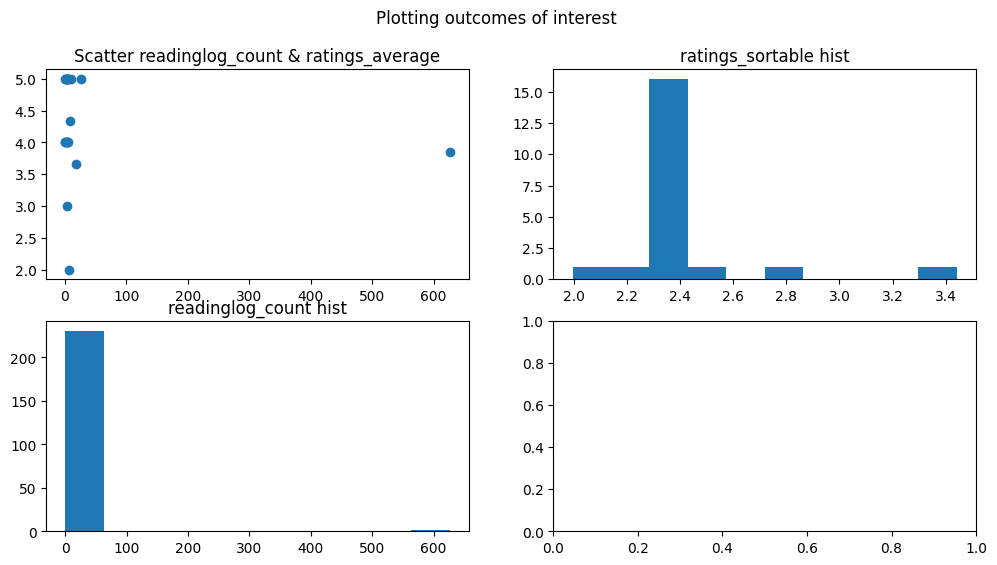

In [170]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs[0,0].set_title('Scatter readinglog_count & ratings_average')
axs[0,0].scatter(df_num['readinglog_count'], df_num['ratings_average'])
axs[0,1].set_title('ratings_sortable hist')
axs[0,1].hist(df_2019['ratings_sortable'])
axs[1,0].set_title('readinglog_count hist')
axs[1,0].hist(df_2019['readinglog_count'])

fig.suptitle('Plotting outcomes of interest')

# From
# plt.hist(df_2019['ratings_sortable'])
# plt.hist(df_2019['readinglog_count'])


Text(0.5, 1.0, 'Number of Pages x Rating Average')

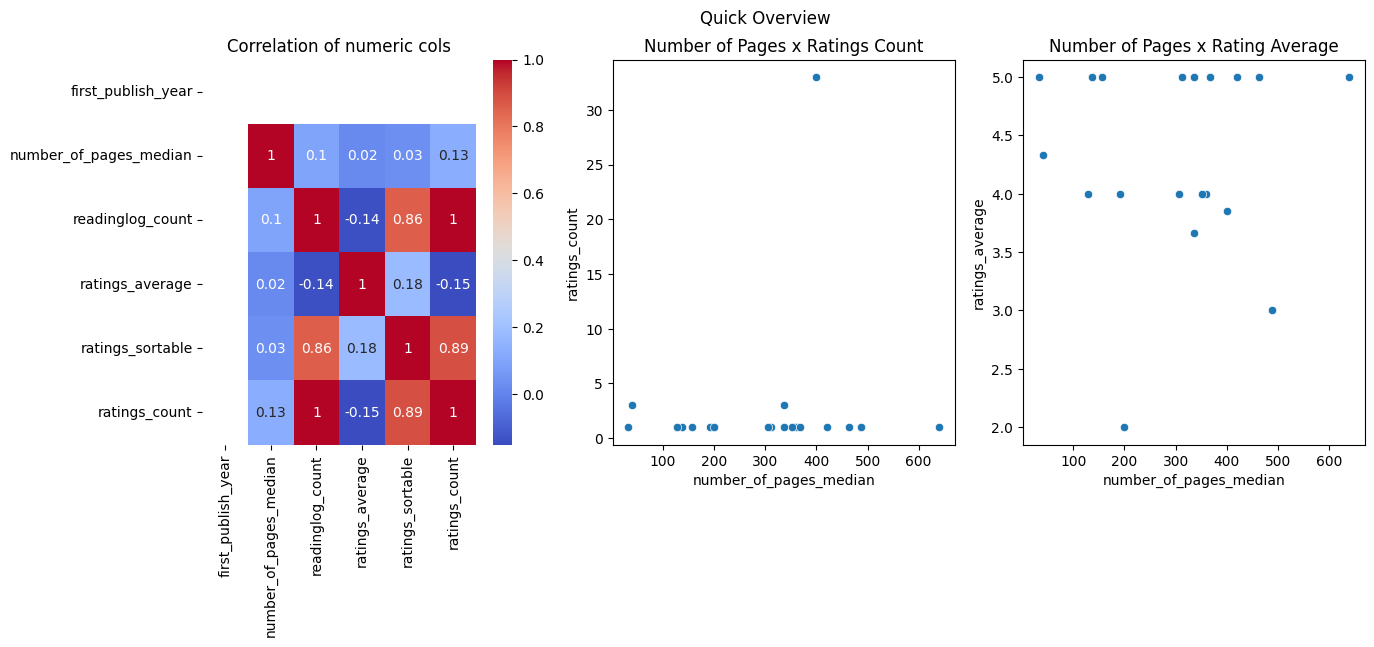

In [171]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Quick Overview')

# Correlation
sns.heatmap(round(df_num.corr(),2), ax=axes[0], cmap = "coolwarm", annot = True)
axes[0].set_title('Correlation of numeric cols')

# Number of Pages x Ratings Count
sns.scatterplot(ax=axes[1], x='number_of_pages_median', y='ratings_count', data=df_2019)
axes[1].set_title('Number of Pages x Ratings Count')

# Number of Pages x Rating Average
sns.scatterplot(ax=axes[2], x='number_of_pages_median', y='ratings_average', data=df_2019)
axes[2].set_title('Number of Pages x Rating Average')

Quick breakdown:
readinglog_count and ratings_count --> r=0.88 makes sense
ratings_sortable is calc'd from ratings_average and ratings_count so relationships with this one are due to leakage
**0.12 ratings_average and number of pages could be interesting**
0 realtionship between ratings_average and ratings_count is also interesting?


### Data Prep

General: 
Duplicates

In [193]:
## Duplicates

# Since it is possible to have the same title for different books AND for one author to have published multiple books, let's

# create a composite column of 'title by author_name'
df_2019['title_author'] = df_2019.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
# print(df_2019[['title', 'author_name', 'title_author']].head())

# check duplicates using this composite column 'title_author' compared to others
print(f"Duplicates: title_author: {df_2019['title_author'].duplicated().sum()} vs title: {df_2019['title'].duplicated().sum()} vs author: {df_2019['author_name'].duplicated().sum()}")

# df_no_duplicates = df.drop_duplicates(subset=['title_author'])
# Drop the author_title column if/when you no longer need it:
# df_no_duplicates = df_no_duplicates.drop(columns=['title_author'])



Duplicates: title_author: 1 vs title: 2 vs author: 75


In [189]:
## Missing data
df_2019.isnull().sum().sort_values(ascending=False) / len(df_2019)


# Analyses that will make use of NA data: 
## read vs not read
## read but not rated, 

# If need to replace missing values, can use sklearn's simple imputer
"""
from sklearn.impute import SimpleImputer

# Instantiate a SimpleImputer object with your strategy of choice
imputer = SimpleImputer(strategy="mean") 

# Call the "fit" method on the object
imputer.fit(data[['Pesos']]) 

# Call the "transform" method on the object
data['Pesos'] = imputer.transform(data[['Pesos']]) 

# The mean is stored in the transformer's memory
imputer.statistics_ 
"""



'\nfrom sklearn.impute import SimpleImputer\n\n# Instantiate a SimpleImputer object with your strategy of choice\nimputer = SimpleImputer(strategy="mean") \n\n# Call the "fit" method on the object\nimputer.fit(data[[\'Pesos\']]) \n\n# Call the "transform" method on the object\ndata[\'Pesos\'] = imputer.transform(data[[\'Pesos\']]) \n\n# The mean is stored in the transformer\'s memory\nimputer.statistics_ \n'

📚 pandas.DataFrame.boxplot
📚 matplotlib.pyplot.boxplot
📚 seaborn.boxplot

In [ ]:
## Outliers
# Is the outlier evidently false? a novelty? Could it be used as a feature?

# boxplot
"""
data[['GrLivArea']].boxplot();

# Evidently false (1)

# Save the indexes corresponding to rows 
# without the absurd ___ value
# and without large mansions (>5000 ft)
boolean_mask = (data['GrLivArea']>0) & (data['GrLivArea']<5000)

# Apply the boolean filtering
data = data[boolean_mask].reset_index(drop=True)

# Visualize the boxplot again
data[['GrLivArea']].boxplot(); 


most famous scalers
**StandardScaler ("Standardizing")**
- --> 📚 sklearn.preprocessing.StandardScaler
- Standardization: Pros & Cons
- ✅ Most efficient when a feature is normally distributed
 - 🆗 Does not ensure an exact common range for two different features...
-❗️ Sensitive to outliers...
-❗️ Can distort relative distances between feature values...

**MinMaxScaler ("Normalizing")**
👉 The feature values are compressed in a fixed range [0,1].
📚 sklearn.preprocessing.MinMaxScaler
MinMax Scaling effects and use cases:
✅ Ensures a fixed range in [0,1]for all the values of a given feature
ℹ️ It neither reduces the effect of outliers nor changes skewness.
👉 Preserves matrix sparsity! (a 0 remains 0 for a positive matrix)
🚀 Go-to scaling for:
Ordinal features (e.g. Olist review score)
Positive features or sparse matrix (for instance: pixel luminosity)
The KNearestNeighbors algorithm (KNN), a distance-based algorithm that we will learn during the Performance Metrics lecture (why?)

**RobustScale**
- Robust Scaling uses:
the median as central tendency metric the interquartile range as dispersion metric.
💪 Both of them are less sensitive to outliers than the mean and the standard deviation!
[Math Processing Error]
📚 sklearn.preprocessing.RobustScaler

Rules of thumb when scaling 👍
Feature Transformation/Engineering

If your feature is extremely skewed
→
consider Feature Engineering first (e.g. log(feature))
Robust Scaler

If your feature transformation doesn't work
→
consider Robust Scaling this feature
If your feature is still heavily skewed with outliers that (you assume to be) irrelevant
→
consider Robust Scaling
Standard Scaler

Otherwise, Standard Scaling is a safe bet.
Before doing a fine-grained selection of which scalers to use for each feature, you can run a model using only Standard Scaling to run the model quickly.
Models like Linear Regression and Neural Networks work quite well with zero-centered features.
MinMax Scaler

If your features form a positive or sparse matrix (e.g. RGB values in a picture between 0 and 255)
→
consider MinMax Scaling
If you think that outliers (if any) are full part of the dataset and shouldn't be removed
→
consider MinMax Scaling
All rules of thumb are subject to exceptions 🙃

In [174]:
# Numerical columns
## Scaling
## distribution: sns.histplot(data['GrLivArea'], bins=200,kde = True);
## boxplot: sns.boxplot(data=data, x='GrLivArea');

## Balancing
⚖️ A 70/30 ratio (class A / class B) split for binary classification can be considered imbalanced

Balancing strategies
Oversampling of minority class
Alternatively, Computation of new instances for the minority class
Undersampling of majority class
Oversampling or Undersampling
Oversampling = duplicating instances of the minority class
Undersampling = sampling down the majority class



❗️ Warning about the oversampling method ❗️
Train-test split your dataset before oversampling
Oversample only in the train set
→
The model needs to learn about the minority class
Evaluate on the test set without oversampling
→
We want the model to be evaluated in real conditions

Synthetic Minority Oversampling TEchnique (SMOTE)

📚 SMOTE documentation

ℹ️ Notice that you have to pip install -U imbalanced-learn

👉 Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.

🚨 Be careful with balancing techniques 🚨

Use balancing techniques only on the training set to help the model learn about the minority class.
The test set should remain representative of the real world.

In [191]:
# Balanced datasets
## Balancing


Encoding

In [ ]:
# Categorical columns
## Encoding
## Discretizing

# Generating new features
## Feature creation

# Using the most relevant features
## Feature selection, Modelling and Feature Permutation